<a href="https://colab.research.google.com/github/Megancodes2017/Megancodes2017/blob/main/Offensive_Profile_Phillies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import statcast_batter, playerid_lookup
from scipy.stats import zscore

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

In [ ]:
# Phillies hitter list

phillies_hitters = [
    'Kyle Schwarber',
    'Bryce Harper',
    'Trea Turner',
    'J.T. Realmuto',
    'Bryson Stott',
    'Alec Bohm',
    'Adolis García',
    'Brandon Marsh',
    'Edmundo Sosa',
    'Rafael Marchán',
    'Otto Kemp'
]

def get_player_id(name):
  # Hardcoded MLBAM IDs for problematic players to ensure they are included
  known_mlbam_ids = {
      'J.T. Realmuto': 592663
  }

  if name in known_mlbam_ids:
      return known_mlbam_ids[name]

  try:
    first, last = name.split()
    lookup = playerid_lookup(last, first)
    if not lookup.empty:
      return lookup.iloc[0]['key_mlbam']
    else:
      print(f"playerid_lookup returned empty for '{name}'. No MLBAM ID found via lookup.")
      return None
  except IndexError:
    print(f"Could not split name or lookup for '{name}'.")
    return None
  except Exception as e:
    print(f"An unexpected error occurred during player ID lookup for '{name}': {e}")
    return None

In [ ]:
# Pull Statcast data

start_date = '2025-03-20'
end_date = '2025-09-30'

all_data = []

for hitter in phillies_hitters:
  player_id = get_player_id(hitter)
  if player_id is None:
      print(f"Skipping player '{hitter}' as their MLBAM ID could not be found or provided.")
      continue

  try:
    data = statcast_batter(start_date, end_date, player_id)
    if not data.empty:
      data['player_name'] = hitter
      all_data.append(data)
    else:
      print(f"No Statcast data found for '{hitter}' (ID: {player_id}) between {start_date} and {end_date}.")
  except Exception as e:
    print(f"Error fetching Statcast data for '{hitter}' (ID: {player_id}): {e}")
    continue

df = pd.concat(all_data)
df = df.reset_index(drop=True)

Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data
Gathering Player Data


In [ ]:
# Define Zone
df['in_zone'] = (
    (df['plate_x'].between(-0.83, 0.83)) &
    (df['plate_z'].between(1.5, 3.5))
)

# Swing Events
swing_events = [
    'swinging_strike', 'foul', 'foup_tip', 'hit_into_play', 'swinging_strike_blocked'
]

df['swing'] = df['description'].isin(swing_events)

# Contact
contact_events = ['foul', 'foul_tip', 'hit_into_play']
df['contact'] = df['description'].isin(contact_events)

# Chase
df['chase'] = (~df['in_zone']) & (df['swing'])

# Whiff
df['whiff'] = df['swing'] & (~df['contact'])

In [ ]:
# Swing Decisions

decision_metrics = df.groupby('player_name').apply(
    lambda x: pd.Series({
        'O-Swing%': x.loc[~x['in_zone'], 'swing'].mean(),
        'Z-Swing%': x.loc[x['in_zone'], 'swing'].mean(),
        'Chase Whiff%': x.loc[x['chase'], 'whiff'].mean()
    }), include_groups=False
).reset_index()

In [ ]:
# Contact Metrics

contact_metrics = df.groupby('player_name').apply(
    lambda x: pd.Series({
        'Contact%': x.loc[x['swing'], 'contact'].mean(),
        'Zone Contact%': x.loc[x['in_zone'] & x['swing'], 'contact'].mean(),
        'Whiff%': x['whiff'].mean()
    }), include_groups=False
).reset_index()

In [ ]:
# Impact Metrics

bip = df[df['type'] == 'X']

impact_metrics = bip.groupby('player_name').apply(
    lambda x: pd.Series({
        'xwOBACON': x['estimated_woba_using_speedangle'].mean(),
        'AVG EV': x['launch_speed'].mean(),
        'Barrel%': x['launch_speed'].gt(98).mean()
    }), include_groups=False
).reset_index()

In [ ]:
# Merge metrics

summary = decision_metrics.merge(contact_metrics, on='player_name')
summary = summary.merge(impact_metrics, on='player_name')

# Standardize

for col in summary.columns[1:]:
  summary[col+"_z"] = zscore(summary[col])

# Composite Offensive Index
summary['Offensive_Index'] = (
    0.35*summary['O-Swing%_z']*-1 +
    0.30*summary['Contact%_z'] +
    0.35*summary['xwOBACON_z']
)

summary = summary.sort_values('Offensive_Index', ascending=False)
summary

,player_name,O-Swing%,Z-Swing%,Chase Whiff%,Contact%,Zone Contact%,Whiff%,xwOBACON,AVG EV,Barrel%,O-Swing%_z,Z-Swing%_z,Chase Whiff%_z,Contact%_z,Zone Contact%_z,Whiff%_z,xwOBACON_z,AVG EV_z,Barrel%_z,Offensive_Index
7,Kyle Schwarber,0.211318,0.627038,0.572650,0.684458,0.782232,0.128312,0.516337,94.454676,0.513189,-1.357810,-0.600892,1.248414,-1.217909,-1.555329,0.370027,2.210658,1.896135,2.052857,0.883591
4,Bryson Stott,0.229305,0.539743,0.263538,0.854545,0.900421,0.056940,0.332049,86.920095,0.219858,-1.076692,-2.113574,-1.543628,1.537046,1.143885,-1.679909,-0.776100,-1.101452,-1.359437,0.566321
1,Alec Bohm,0.274466,0.653125,0.250000,0.867968,0.913876,0.062196,0.359634,90.873980,0.348485,-0.370839,-0.148849,-1.665909,1.754453,1.451169,-1.528939,-0.329036,0.471577,0.136865,0.540967
2,Brandon Marsh,0.276765,0.635167,0.469136,0.777778,0.890772,0.100350,0.413756,90.496071,0.355872,-0.334895,-0.460023,0.313429,0.293615,0.923528,-0.433078,0.548122,0.321228,0.222797,0.397141
6,J.T. Realmuto,0.314114,0.637383,0.408219,0.778415,0.878299,0.103943,0.380992,90.123158,0.357895,0.248846,-0.421628,-0.236799,0.303929,0.638668,-0.329892,0.017113,0.172867,0.246329,0.010072
10,Trea Turner,0.298869,0.709836,0.483784,0.765372,0.871824,0.117982,0.355511,89.359470,0.323829,0.010580,0.833859,0.445736,0.092677,0.490799,0.073347,-0.395846,-0.130962,-0.149955,-0.114446
3,Bryce Harper,0.331153,0.764706,0.511111,0.703925,0.817471,0.155885,0.424077,90.647044,0.380463,0.515165,1.784660,0.692570,-0.902604,-0.750541,1.161987,0.715393,0.381292,0.508860,-0.200701
9,Rafael Marchán,0.242798,0.618474,0.372881,0.793427,0.857143,0.089431,0.257149,85.309474,0.164948,-0.865789,-0.749294,-0.555986,0.547094,0.155498,-0.746696,-1.990002,-1.742228,-1.998196,-0.229346
8,Otto Kemp,0.297619,0.715711,0.624000,0.669903,0.797909,0.165652,0.410486,89.446970,0.371212,-0.008959,0.935657,1.712235,-1.453669,-1.197283,1.442504,0.495123,-0.096151,0.401249,-0.259672
0,Adolis García,0.347938,0.690181,0.439506,0.710363,0.794199,0.147763,0.378803,92.345714,0.371134,0.777513,0.493272,0.045800,-0.798322,-1.282024,0.928715,-0.018361,1.057097,0.400340,-0.518052


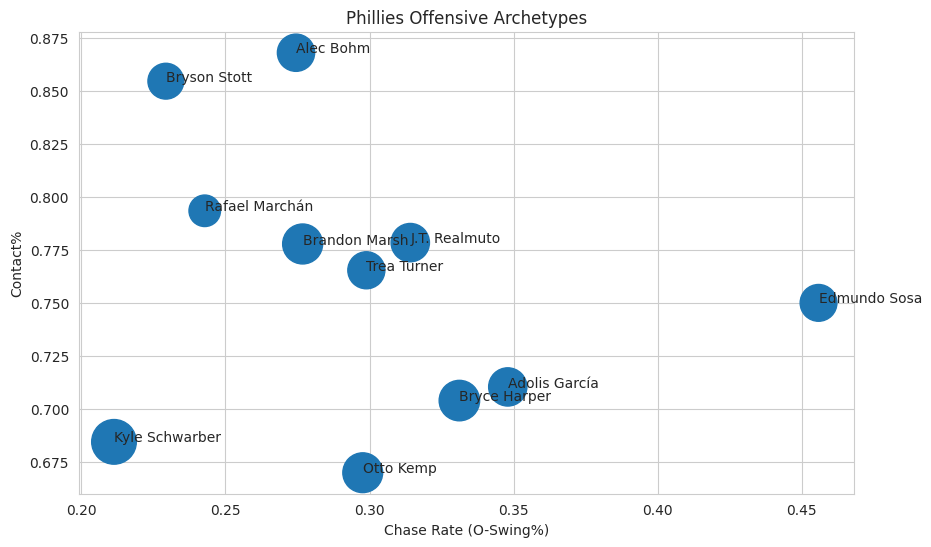

In [ ]:
# Visual 1: Offensive Archtype Scatter

# X = Discipline, Y = Contact, Bubble = Impact

plt.figure()

plt.scatter(
    summary['O-Swing%'],
    summary['Contact%'],
    summary['xwOBACON']*2000,
)

for i, row in summary.iterrows():
  plt.text(row['O-Swing%'], row['Contact%'], row['player_name'])

plt.xlabel('Chase Rate (O-Swing%)')
plt.ylabel('Contact%')
plt.title('Phillies Offensive Archetypes')
plt.show()

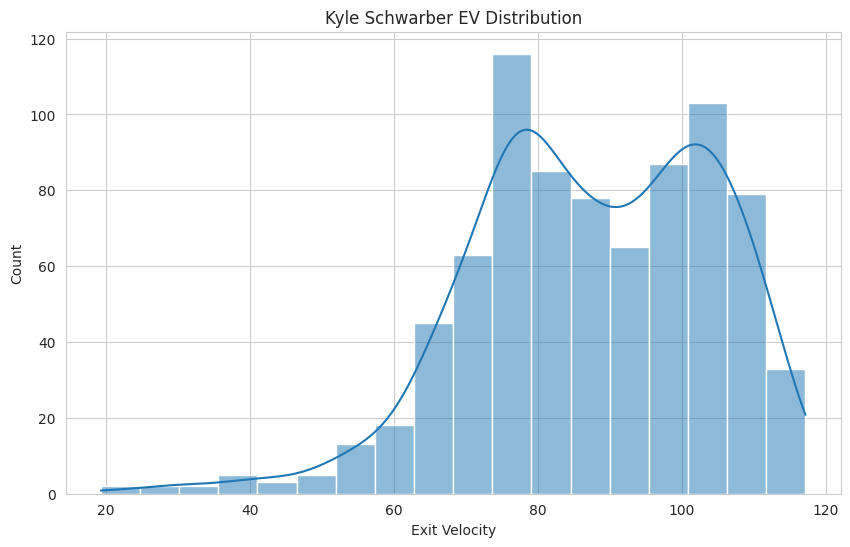

In [ ]:
# EV Distribution (Impact Profile)
schwarber = df[df['player_name'] == 'Kyle Schwarber']
sns.histplot(schwarber['launch_speed'], kde=True)
plt.title('Kyle Schwarber EV Distribution')
plt.xlabel('Exit Velocity')
plt.show()

In [ ]:
# Pitch Family Classification

fastballs = ['FF', 'SI', 'FC']
breaking = ['SL', 'CU', 'KC', 'ST']
offspeed = ['CH', 'FS', 'FO']

def classify_pitch(pitch):
  if pitch in fastballs:
    return 'Fastball'
  elif pitch in breaking:
    return 'Breaking'
  elif pitch in offspeed:
    return 'Offspeed'
  else:
    return 'Other'

df['pitch_type'] = df['pitch_type'].apply(classify_pitch)

In [ ]:
# Filter balls in play only, wOBACON = wOBA on contact only

bip = df[df['type'] == 'X'].copy()

In [ ]:
# Calculate pitch type specific wOBACON

pitch_wobacon = bip.groupby(
    ['player_name', 'pitch_type']
).apply(
    lambda x: pd.Series({
        'wOBACON': x['estimated_woba_using_speedangle'].mean(),
        'AVG_EV': x['launch_speed'].mean(),
        'BIP_Count': len(x)
    })
).reset_index()

/tmp/ipython-input-1253279774.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(


In [ ]:
# Pivot for clean visualization

pivot_wobacon = pitch_wobacon.pivot(
    index='player_name',
    columns='pitch_type',
    values='wOBACON'
)

pivot_wobacon

pitch_type,Breaking,Fastball,Offspeed,Other
player_name,,,,
Adolis García,0.338745,0.398358,0.365334,0.434800
Alec Bohm,0.346601,0.370074,0.340124,0.358000
Brandon Marsh,0.452506,0.402116,0.399817,0.330667
Bryce Harper,0.379179,0.478910,0.385290,0.263957
Bryson Stott,0.344535,0.346334,0.274001,0.279333
Edmundo Sosa,0.380212,0.332145,0.354992,0.330667
J.T. Realmuto,0.374851,0.388050,0.339034,0.700238
Kyle Schwarber,0.421223,0.576487,0.478777,0.368333
Otto Kemp,0.418813,0.406263,0.411604,0.326000


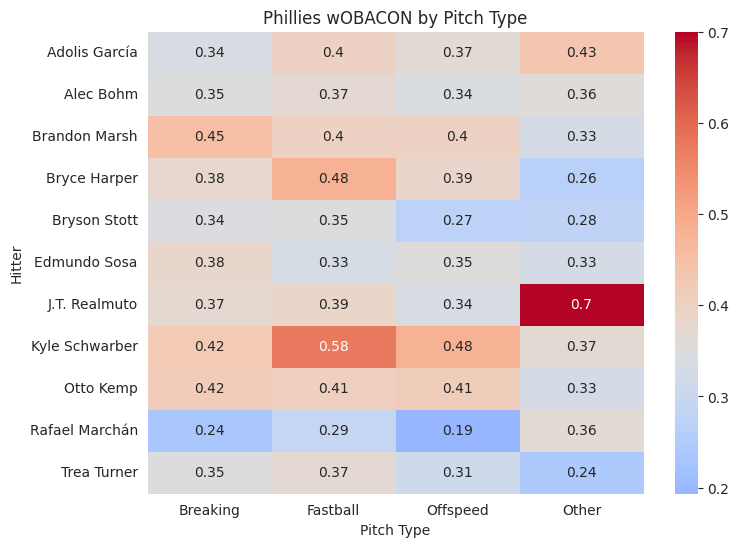

In [ ]:
# Visualization 1 - Heatmap

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot_wobacon,
    annot=True,
    cmap='coolwarm',
    center=.350
)

plt.title('Phillies wOBACON by Pitch Type')
plt.ylabel('Hitter')
plt.xlabel('Pitch Type')
plt.show()

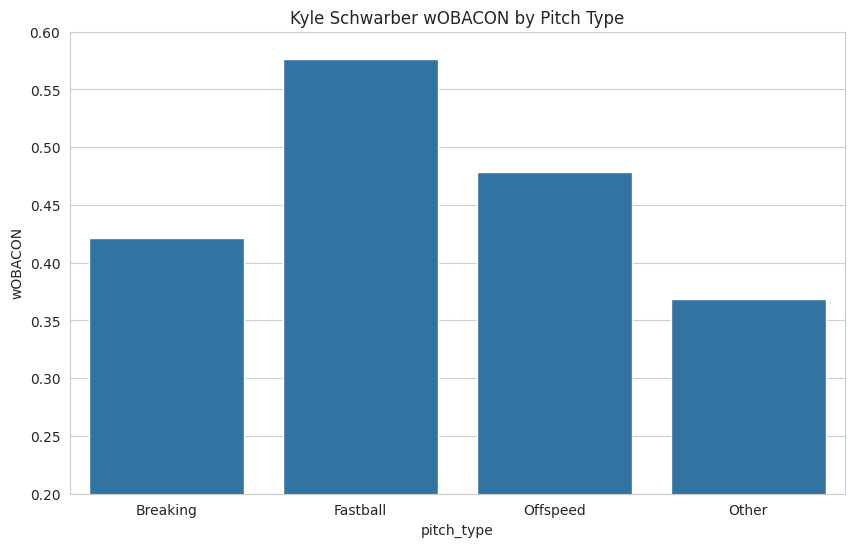

In [ ]:
# Individual player

kyle_pitch = pitch_wobacon[pitch_wobacon['player_name'] == 'Kyle Schwarber']

plt.figure()
sns.barplot(
    data=kyle_pitch,
    x='pitch_type',
    y='wOBACON'
)

plt.title('Kyle Schwarber wOBACON by Pitch Type')
plt.ylabel('wOBACON')
plt.ylim(.200, .600)
plt.show()

In [ ]:
print(summary.to_markdown(index=False))
print("Displayed the summary DataFrame.")

| player_name    |   O-Swing% |   Z-Swing% |   Chase Whiff% |   Contact% |   Zone Contact% |    Whiff% |   xwOBACON |   AVG EV |   Barrel% |   O-Swing%_z |   Z-Swing%_z |   Chase Whiff%_z |   Contact%_z |   Zone Contact%_z |   Whiff%_z |   xwOBACON_z |   AVG EV_z |   Barrel%_z |   Offensive_Index |
|:---------------|-----------:|-----------:|---------------:|-----------:|----------------:|----------:|-----------:|---------:|----------:|-------------:|-------------:|-----------------:|-------------:|------------------:|-----------:|-------------:|-----------:|------------:|------------------:|
| Kyle Schwarber |   0.211318 |   0.627038 |       0.57265  |   0.684458 |        0.782232 | 0.128312  |   0.516337 |  94.4547 |  0.513189 |  -1.35781    |    -0.600892 |        1.24841   |   -1.21791   |        -1.55533   |  0.370027  |    2.21066   |  1.89613   |    2.05286  |         0.883591  |
| Bryson Stott   |   0.229305 |   0.539743 |       0.263538 |   0.854545 |        0.900421 | 0.05693

In [ ]:
# Classify players based on their plate discipline, contact ability and power output using their z-scores

In [ ]:
def classify_archetype(row):
    discipline_score = row['O-Swing%_z'] * -1 # Higher negative O-Swing is good
    contact_score = row['Contact%_z']
    impact_score = row['xwOBACON_z']

    # Power Hitter
    if impact_score > 1.0 and discipline_score > -0.5:
        return 'Power Hitter (Good Eye)'
    if impact_score > 1.0 and discipline_score < -0.5:
        return 'Power Hitter (Aggressive)'

    # High Contact / On-Base Threat
    if contact_score > 1.0 and discipline_score > 0.5:
        return 'High Contact / OBP Threat'

    # Balanced / All-around
    if -0.5 < discipline_score < 0.5 and -0.5 < contact_score < 0.5 and -0.5 < impact_score < 0.5:
        return 'Balanced Hitter'

    # Aggressive / Free Swinger
    if discipline_score < -1.0 and contact_score < -1.0:
        return 'Aggressive Free Swinger'

    # Weak contact / Low Impact
    if impact_score < -1.0 and contact_score > -0.5:
        return 'Low Impact / High Contact'

    return 'Other Archetype'

summary['Archetype'] = summary.apply(classify_archetype, axis=1)
print(summary[['player_name', 'Offensive_Index', 'Archetype']].to_markdown(index=False))

| player_name    |   Offensive_Index | Archetype                 |
|:---------------|------------------:|:--------------------------|
| Kyle Schwarber |         0.883591  | Power Hitter (Good Eye)   |
| Bryson Stott   |         0.566321  | High Contact / OBP Threat |
| Alec Bohm      |         0.540967  | Other Archetype           |
| Brandon Marsh  |         0.397141  | Other Archetype           |
| J.T. Realmuto  |         0.0100721 | Balanced Hitter           |
| Trea Turner    |        -0.114446  | Balanced Hitter           |
| Bryce Harper   |        -0.200701  | Other Archetype           |
| Rafael Marchán |        -0.229346  | Low Impact / High Contact |
| Otto Kemp      |        -0.259672  | Other Archetype           |
| Adolis García  |        -0.518052  | Other Archetype           |
| Edmundo Sosa   |        -1.07587   | Other Archetype           |


In [ ]:
# Verify is 'p_throws' column is within df

In [ ]:
print("DataFrame columns:")
print(df.columns)

if 'p_throws' in df.columns:
    print("\n'p_throws' column exists. Unique values and counts:")
    print(df['p_throws'].value_counts())
else:
    print("\n'p_throws' column does not exist in the DataFrame.")

DataFrame columns:
Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'attack_angle', 'attack_direction', 'swing_path_tilt',
       'intercept_ball_minus_batter_pos_x_inches',
       'intercept_ball_minus_batter_pos_y_inches', 'in_zone', 'swing',
       'contact', 'chase', 'whiff'],
      dtype='object', length=123)

'p_throws' column exists. Unique values and counts:
p_throws
R    14294
L     6357
Name: count, dtype: int64


In [ ]:
# Recalculate metrics for right handed pitching split

In [ ]:
df_rhp = df[df['p_throws'] == 'R'].copy()
print("Filtered df for RHP into df_rhp.")

Filtered df for RHP into df_rhp.


In [ ]:
# Calculate decision metrics for each player using df_rhp

In [ ]:
decision_metrics_rhp = df_rhp.groupby('player_name').apply(
    lambda x: pd.Series({
        'O-Swing%': x.loc[~x['in_zone'], 'swing'].mean(),
        'Z-Swing%': x.loc[x['in_zone'], 'swing'].mean(),
        'Chase Whiff%': x.loc[x['chase'], 'whiff'].mean()
    }), include_groups=False
).reset_index()
print("Calculated decision metrics for RHP.")

Calculated decision metrics for RHP.


In [ ]:
# Calculate contact metrics for each player using df_rhp

In [ ]:
contact_metrics_rhp = df_rhp.groupby('player_name').apply(
    lambda x: pd.Series({
        'Contact%': x.loc[x['swing'], 'contact'].mean(),
        'Zone Contact%': x.loc[x['in_zone'] & x['swing'], 'contact'].mean(),
        'Whiff%': x['whiff'].mean()
    }), include_groups=False
).reset_index()
print("Calculated contact metrics for RHP.")

Calculated contact metrics for RHP.


In [ ]:
# Filter balls in play against RHP

In [ ]:
bip_rhp = df_rhp[df_rhp['type'] == 'X'].copy()
print("Filtered df_rhp for balls in play into bip_rhp.")

Filtered df_rhp for balls in play into bip_rhp.


In [ ]:
# Calculate impact metrics for each player using df_rhp

In [ ]:
impact_metrics_rhp = bip_rhp.groupby('player_name').apply(
    lambda x: pd.Series({
        'xwOBACON': x['estimated_woba_using_speedangle'].mean(),
        'AVG EV': x['launch_speed'].mean(),
        'Barrel%': x['launch_speed'].gt(98).mean()
    }), include_groups=False
).reset_index()
print("Calculated impact metrics for RHP.")

Calculated impact metrics for RHP.


In [ ]:
# Merge calculated decision, contact and impact metrics for RHP into summary_rhp

In [ ]:
summary_rhp = decision_metrics_rhp.merge(contact_metrics_rhp, on='player_name')
summary_rhp = summary_rhp.merge(impact_metrics_rhp, on='player_name')
print("Merged RHP metrics into summary_rhp.")

Merged RHP metrics into summary_rhp.


In [ ]:
# Calculate the z-scores for all metrics columns

In [ ]:
for col in summary_rhp.columns[1:]:
  summary_rhp[col+"_z"] = zscore(summary_rhp[col])
print("Calculated z-scores for RHP metrics.")

Calculated z-scores for RHP metrics.


In [ ]:
# Calculate the Offensive Index for summary_rhp

In [ ]:
summary_rhp['Offensive_Index'] = (
    0.35 * summary_rhp['O-Swing%_z'] * -1 +
    0.30 * summary_rhp['Contact%_z'] +
    0.35 * summary_rhp['xwOBACON_z']
)
print("Computed Offensive_Index for RHP metrics.")

Computed Offensive_Index for RHP metrics.


In [ ]:
# Sort the summary_rhp DataFrame by Offensive Index in decending order

In [ ]:
summary_rhp = summary_rhp.sort_values('Offensive_Index', ascending=False)
print("Sorted summary_rhp by Offensive_Index.")

Sorted summary_rhp by Offensive_Index.


In [ ]:
# Apply the classify_archetype function to the summary_rhp DataFrame to assign an archetype to each player based on their performance vs RHP

In [ ]:
summary_rhp['Archetype'] = summary_rhp.apply(classify_archetype, axis=1)
print(summary_rhp[['player_name', 'Offensive_Index', 'Archetype']].to_markdown(index=False))
print("Applied classify_archetype to summary_rhp and displayed the result.")

| player_name    |   Offensive_Index | Archetype                 |
|:---------------|------------------:|:--------------------------|
| Kyle Schwarber |         0.86881   | Power Hitter (Good Eye)   |
| Bryson Stott   |         0.724397  | High Contact / OBP Threat |
| Alec Bohm      |         0.618147  | Other Archetype           |
| Brandon Marsh  |         0.571107  | Other Archetype           |
| Bryce Harper   |         0.0206765 | Other Archetype           |
| J.T. Realmuto  |         0.0155304 | Balanced Hitter           |
| Trea Turner    |        -0.203904  | Balanced Hitter           |
| Otto Kemp      |        -0.267204  | Other Archetype           |
| Adolis García  |        -0.580361  | Other Archetype           |
| Rafael Marchán |        -0.595962  | Low Impact / High Contact |
| Edmundo Sosa   |        -1.17124   | Other Archetype           |
Applied classify_archetype to summary_rhp and displayed the result.


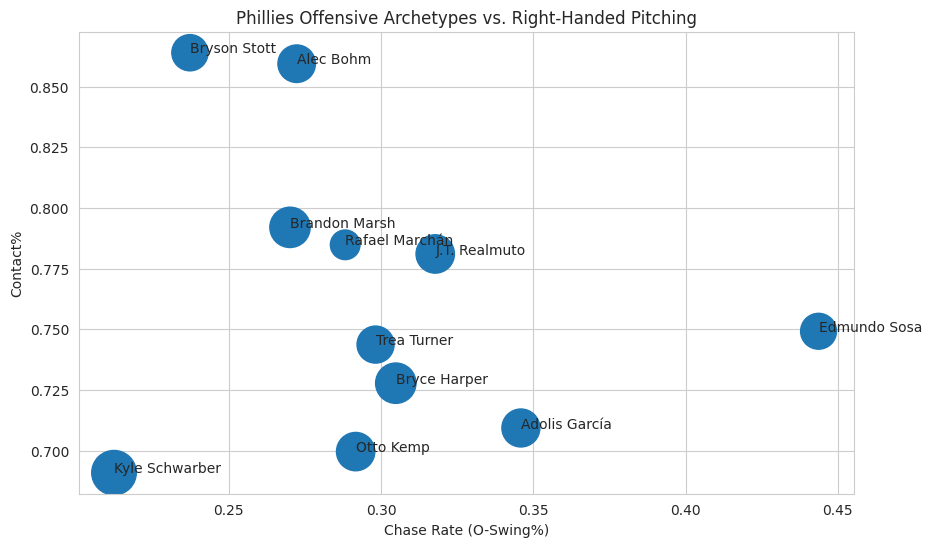

In [ ]:
# Visual : Offensive Archtype Scatter - vs. Right Handed Pitching

# X = Discipline, Y = Contact, Bubble = Impact

plt.figure()

plt.scatter(
    summary_rhp['O-Swing%'],
    summary_rhp['Contact%'],
    summary_rhp['xwOBACON']*2000,
)

for i, row in summary_rhp.iterrows():
  plt.text(row['O-Swing%'], row['Contact%'], row['player_name'])

plt.xlabel('Chase Rate (O-Swing%)')
plt.ylabel('Contact%')
plt.title('Phillies Offensive Archetypes vs. Right-Handed Pitching')
plt.show()

In [ ]:
# Recalculate metrics for left handed pitching split

In [ ]:
df_lhp = df[df['p_throws'] == 'L'].copy()
print("Filtered df for LHP into df_lhp.")

Filtered df for LHP into df_lhp.


In [ ]:
# Calculate decision metrics for each player using df_lhp

In [ ]:
decision_metrics_lhp = df_lhp.groupby('player_name').apply(
    lambda x: pd.Series({
        'O-Swing%': x.loc[~x['in_zone'], 'swing'].mean(),
        'Z-Swing%': x.loc[x['in_zone'], 'swing'].mean(),
        'Chase Whiff%': x.loc[x['chase'], 'whiff'].mean()
    }), include_groups=False
).reset_index()
print("Calculated decision metrics for LHP.")

Calculated decision metrics for LHP.


In [ ]:
# Calculate contact metrics for each player using df_lhp

In [ ]:
contact_metrics_lhp = df_lhp.groupby('player_name').apply(
    lambda x: pd.Series({
        'Contact%': x.loc[x['swing'], 'contact'].mean(),
        'Zone Contact%': x.loc[x['in_zone'] & x['swing'], 'contact'].mean(),
        'Whiff%': x['whiff'].mean()
    }), include_groups=False
).reset_index()
print("Calculated contact metrics for LHP.")

Calculated contact metrics for LHP.


In [ ]:
# Filter df_lhp to include only balls in play

In [ ]:
bip_lhp = df_lhp[df_lhp['type'] == 'X'].copy()
print("Filtered df_lhp for balls in play into bip_lhp.")

Filtered df_lhp for balls in play into bip_lhp.


In [ ]:
# Calculate impact metrics for each player using bip_lhp

In [ ]:
impact_metrics_lhp = bip_lhp.groupby('player_name').apply(
    lambda x: pd.Series({
        'xwOBACON': x['estimated_woba_using_speedangle'].mean(),
        'AVG EV': x['launch_speed'].mean(),
        'Barrel%': x['launch_speed'].gt(98).mean()
    }), include_groups=False
).reset_index()
print("Calculated impact metrics for LHP.")

Calculated impact metrics for LHP.


In [ ]:
# Merge calculated decision, contact and impact metrics for LHP into summary_lhp

In [ ]:
summary_lhp = decision_metrics_lhp.merge(contact_metrics_lhp, on='player_name')
summary_lhp = summary_lhp.merge(impact_metrics_lhp, on='player_name')
print("Merged LHP metrics into summary_lhp.")

Merged LHP metrics into summary_lhp.


In [ ]:
# Calculate the z scores for all metrics columns and append '_z' to the new z-score column names

In [ ]:
for col in summary_lhp.columns[1:]:
  summary_lhp[col+"_z"] = zscore(summary_lhp[col])
print("Calculated z-scores for LHP metrics.")

Calculated z-scores for LHP metrics.


In [ ]:
# Compute the Offensive Index for summary_lhp

In [ ]:
summary_lhp['Offensive_Index'] = (
    0.35 * summary_lhp['O-Swing%_z'] * -1 +
    0.30 * summary_lhp['Contact%_z'] +
    0.35 * summary_lhp['xwOBACON_z']
)
print("Computed Offensive_Index for LHP metrics.")

Computed Offensive_Index for LHP metrics.


In [ ]:
# Sort the summary_lhp DataFrame by 'Offensive Index' in decending order

In [ ]:
summary_lhp = summary_lhp.sort_values('Offensive_Index', ascending=False)
print(summary_lhp.to_markdown(index=False))
print("Sorted summary_lhp by Offensive_Index and displayed it.")

| player_name    |   O-Swing% |   Z-Swing% |   Chase Whiff% |   Contact% |   Zone Contact% |    Whiff% |   xwOBACON |   AVG EV |   Barrel% |   O-Swing%_z |   Z-Swing%_z |   Chase Whiff%_z |   Contact%_z |   Zone Contact%_z |   Whiff%_z |   xwOBACON_z |   AVG EV_z |   Barrel%_z |   Offensive_Index |
|:---------------|-----------:|-----------:|---------------:|-----------:|----------------:|----------:|-----------:|---------:|----------:|-------------:|-------------:|-----------------:|-------------:|------------------:|-----------:|-------------:|-----------:|------------:|------------------:|
| Kyle Schwarber |   0.209571 |   0.629758 |       0.598425 |   0.674134 |        0.769231 | 0.135135  |   0.519525 |  91.6312 |  0.43949  |   -0.978934  |   -0.316751  |        1.10474   |   -0.972418  |         -1.31192  |  0.357209  |    2.12014   |   0.901328 |  1.0243     |         0.792949  |
| Rafael Marchán |   0.136986 |   0.6      |       0.4      |   0.818182 |        0.866667 | 0.06756

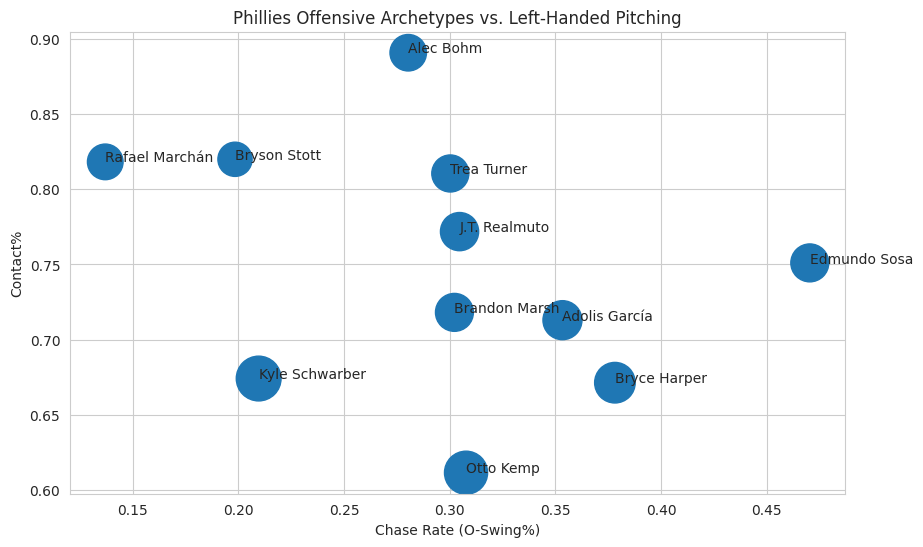

In [ ]:
# Visual : Offensive Archtype Scatter - vs. Left Handed Pitching

# X = Discipline, Y = Contact, Bubble = Impact

plt.figure()

plt.scatter(
    summary_lhp['O-Swing%'],
    summary_lhp['Contact%'],
    summary_lhp['xwOBACON']*2000,
)

for i, row in summary_lhp.iterrows():
  plt.text(row['O-Swing%'], row['Contact%'], row['player_name'])

plt.xlabel('Chase Rate (O-Swing%)')
plt.ylabel('Contact%')
plt.title('Phillies Offensive Archetypes vs. Left-Handed Pitching')
plt.show()

In [ ]:
# Apply the classify_archetype function to the summary_lhp DataFrame to determine each player's offensive performance agasint LHP

In [ ]:
summary_lhp['Archetype'] = summary_lhp.apply(classify_archetype, axis=1)
print(summary_lhp[['player_name', 'Offensive_Index', 'Archetype']].to_markdown(index=False))
print("Applied classify_archetype to summary_lhp and displayed the result.")

| player_name    |   Offensive_Index | Archetype                 |
|:---------------|------------------:|:--------------------------|
| Kyle Schwarber |         0.792949  | Power Hitter (Good Eye)   |
| Rafael Marchán |         0.556719  | Other Archetype           |
| Alec Bohm      |         0.348234  | Other Archetype           |
| Bryson Stott   |         0.169806  | Low Impact / High Contact |
| Trea Turner    |         0.0195005 | Other Archetype           |
| J.T. Realmuto  |        -0.0182606 | Balanced Hitter           |
| Otto Kemp      |        -0.0576558 | Power Hitter (Good Eye)   |
| Brandon Marsh  |        -0.245381  | Balanced Hitter           |
| Adolis García  |        -0.347607  | Other Archetype           |
| Bryce Harper   |        -0.423952  | Other Archetype           |
| Edmundo Sosa   |        -0.794353  | Other Archetype           |
Applied classify_archetype to summary_lhp and displayed the result.


In [ ]:
# Compare summary_rhp and summary_lhp DataFrames

In [ ]:
print('--- Summary against RHP ---')
print(summary_rhp.to_markdown(index=False))

--- Summary against RHP ---
| player_name    |   O-Swing% |   Z-Swing% |   Chase Whiff% |   Contact% |   Zone Contact% |    Whiff% |   xwOBACON |   AVG EV |   Barrel% |   O-Swing%_z |   Z-Swing%_z |   Chase Whiff%_z |   Contact%_z |   Zone Contact%_z |   Whiff%_z |   xwOBACON_z |   AVG EV_z |   Barrel%_z |   Offensive_Index | Archetype                 |
|:---------------|-----------:|-----------:|---------------:|-----------:|----------------:|----------:|-----------:|---------:|----------:|-------------:|-------------:|-----------------:|-------------:|------------------:|-----------:|-------------:|-----------:|------------:|------------------:|:--------------------------|
| Kyle Schwarber |   0.212322 |   0.62528  |       0.558036 |   0.690932 |        0.790698 | 0.124166  |   0.514343 |  96.1596 |  0.557692 |  -1.49308    |    -0.708852 |         1.26578  |    -1.29181  |       -1.56269    |   0.347079 |   2.09651    |  2.09059   |   2.30481   |         0.86881   | Power Hitter (Go

In [ ]:
print('\n--- Summary against LHP ---')
print(summary_lhp.to_markdown(index=False))


--- Summary against LHP ---
| player_name    |   O-Swing% |   Z-Swing% |   Chase Whiff% |   Contact% |   Zone Contact% |    Whiff% |   xwOBACON |   AVG EV |   Barrel% |   O-Swing%_z |   Z-Swing%_z |   Chase Whiff%_z |   Contact%_z |   Zone Contact%_z |   Whiff%_z |   xwOBACON_z |   AVG EV_z |   Barrel%_z |   Offensive_Index | Archetype                 |
|:---------------|-----------:|-----------:|---------------:|-----------:|----------------:|----------:|-----------:|---------:|----------:|-------------:|-------------:|-----------------:|-------------:|------------------:|-----------:|-------------:|-----------:|------------:|------------------:|:--------------------------|
| Kyle Schwarber |   0.209571 |   0.629758 |       0.598425 |   0.674134 |        0.769231 | 0.135135  |   0.519525 |  91.6312 |  0.43949  |   -0.978934  |   -0.316751  |        1.10474   |   -0.972418  |         -1.31192  |  0.357209  |    2.12014   |   0.901328 |  1.0243     |         0.792949  | Power Hitter (G